# Generating synthetic MV CT image from kV CT image

This notebook demonstrates the steps for generating an image with the characteristics of a megavoltage (MV) computed-tomography (CT) scan, starting from a (downsampled) kilovoltage (kV) CT scan, used in radiotherapy planning.

In [1]:
# Import relevant modules, and perform initial setup.

from random import randint, shuffle
from pathlib import Path

from matplotlib.pyplot import rc

from skrt import Image, Patient
from skrt.better_viewer import BetterViewer

# Define paths to data.
patient_dir = Path('~/data').expanduser();
patient_paths = list(patient_dir.glob('head_and_neck/v*/3*multi*/VT*'));

# Set Matplotlib runtime configuration.
# For details of Matplotlib configuration, see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# Sizes are in points.

# For axes, set spacing (pad) and size of label and title
rc("axes", labelpad=0, labelsize=25, titlepad=17, titlesize=25);

# Set default text charactieristics.
# Possible weight values are:
# 100, 200, 300, 400 / "normal", 500, 600, 700 / "bold", 800, 900.
rc("font", family="serif", serif=["Times"], size=20, weight=400);

# Set mathematics typeface when using matplotlib's built-in fonts.
rc("mathtext", fontset="dejavuserif");

# Use TeX/LaTeX for typesetting.  (This requires working TeX/LaTeX installation.)
rc("text", usetex=True)

# For ticks, set label size and direction ("in", "out", "inout").
rc(("xtick", "ytick"), labelsize=25, direction="out");

# For major and minor ticks, set size and width.
# For major ticks, set spacing (pad) of label.
rc(("xtick.major"), pad=3);
rc(("xtick.major", "ytick.major"), size=9, width=1.0);
rc(("xtick.minor", "ytick.minor"), size=4.5, width=1.0);
rc(("ytick.major"), pad=2);

# Create dictionary of BetterViewer image-display options.
view_opts = {
    # Set figure size in inches.
    "figsize": (18, 8),
    # Show major ticks at specified interval (axis units).
    "major_ticks": 60,
    # Show minor ticks for specified number of intervals between major ticks.
    "minor_ticks": 5,
    # Indicate whether axis units should be mm or numbers of voxels.
    "scale_in_mm" : True,
    # Indicate whether ticks should be shown on all sides.
    "ticks_all_sides": True,
    # Include y-tick labels for all plots, not only the first.
    "ytick_labels_first_only": False,
    # Specify zoom factor.
    "zoom": 1.5,
    # Set grey-level minimum and maximum (Hounsfield units).
    "intensity": (-200, 300),
    # Show grey-level scale.
    "colorbar": True,
    # Overlay default image annotation (slice z-coordinate), in white, at default position (top left or image).
    "annotate_slice": {"color": "white", "fontsize": 28},
    # Make display interactive ("no_ui": False) or non-interactive ("no_ui": True).
    "no_ui": True,
    # Set titles.
    "title": ["kV CT", "MV CT"],
};

Load patient data.

In [2]:
p = Patient(patient_paths[0]);

Access Image objects for kV CT scan and MV CT scan, print out image geometries, different for the two CT scans, and display the images as loaded.  The centre slice is shown in each case, so that the slice coordinate and anatomical location are different. 

Shape: (256, 256, 114)
Voxel size: ('2.1480', '2.1480', '3.0000')
Origin: ('-274.4630', '-274.4630', '-222.0000')
Extent: ('(-275.5370, 274.3510)', '(-275.5370, 274.3510)', '(-223.5000, 118.5000)')
Image size: ('549.8880', '549.8880', '342.0000')

Shape: (512, 512, 32)
Voxel size: ('0.7647', '0.7647', '6.0000')
Origin: ('-195.9618', '-195.9618', '-154.5000')
Extent: ('(-196.3442, 195.1822)', '(-196.3442, 195.1822)', '(-157.5000, 34.5001)')
Image size: ('391.5264', '391.5264', '192.0001')


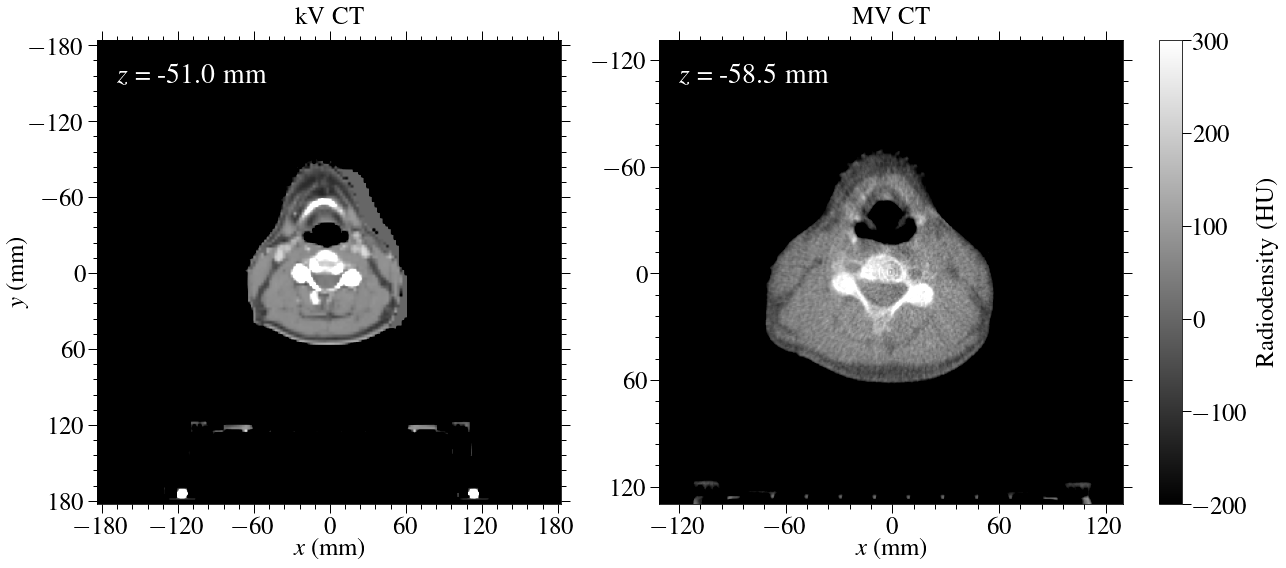

In [3]:
ct = p.studies[0].ct_images[0];
mvct = p.studies[0].mvct_images[0];

ct.print_geometry();
print();
mvct.print_geometry();

BetterViewer(images=[ct, mvct], **view_opts);

Remove from the kV CT scan the virtual bolus added at the time of treatment planning to influence the treatment optimisation.

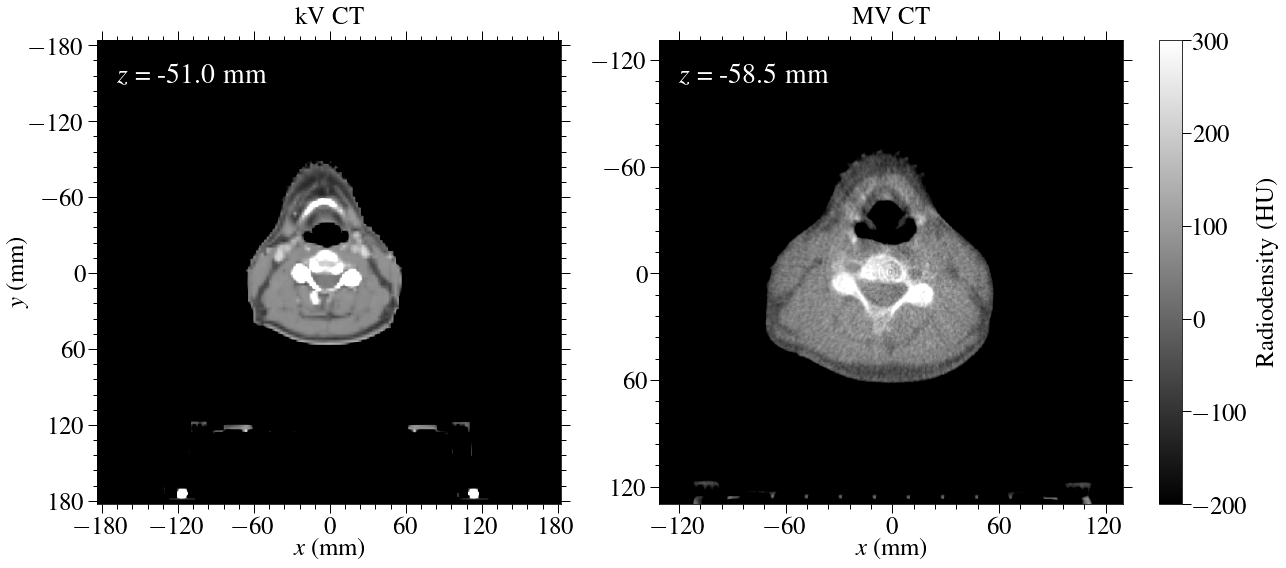

In [4]:
ct.remove_bolus();
BetterViewer(images=[ct, mvct], **view_opts);

Apply masks to select only the foregrounds of the two images.

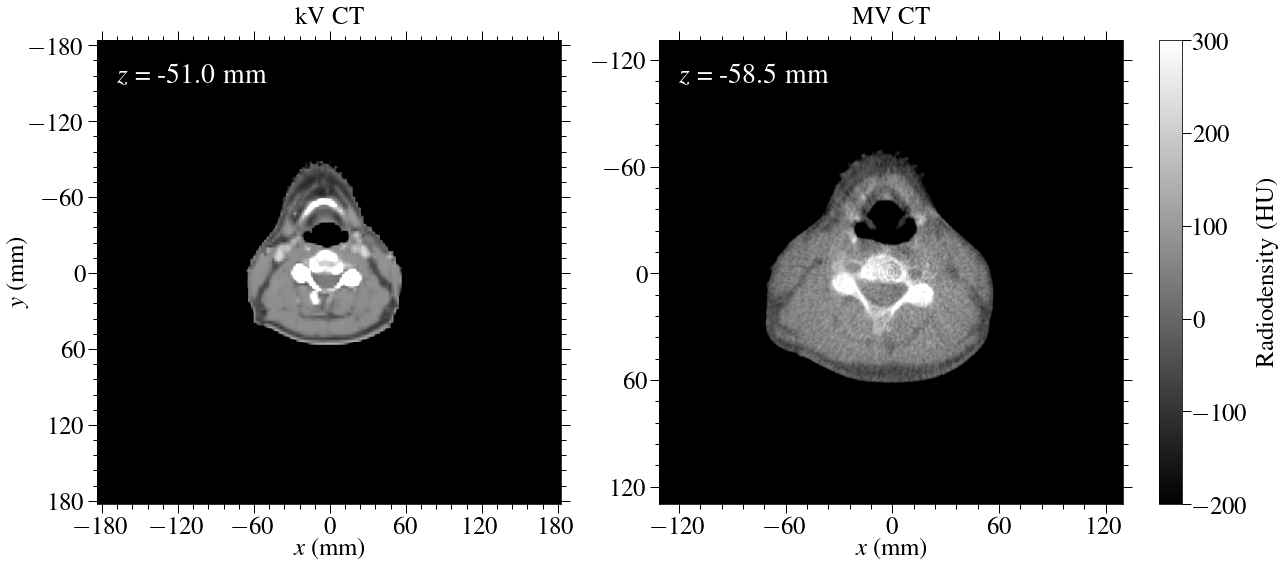

In [5]:
ct.select_foreground();
mvct.select_foreground();
BetterViewer(images=[ct, mvct], **view_opts);

Resize the kV CT image, so as to match the geometry of the MV CT image.  The centre slices of the two images now have the same coordinate, and correspond to approximately the same anatomical location.

Shape: (512, 512, 32)
Voxel size: ('0.7647', '0.7647', '6.0000')
Origin: ('-195.9618', '-195.9618', '-154.5000')
Extent: ('(-196.3442, 195.1822)', '(-196.3442, 195.1822)', '(-157.5000, 34.5001)')
Image size: ('391.5264', '391.5264', '192.0001')

Shape: (512, 512, 32)
Voxel size: ('0.7647', '0.7647', '6.0000')
Origin: ('-195.9618', '-195.9618', '-154.5000')
Extent: ('(-196.3442, 195.1822)', '(-196.3442, 195.1822)', '(-157.5000, 34.5001)')
Image size: ('391.5264', '391.5264', '192.0001')


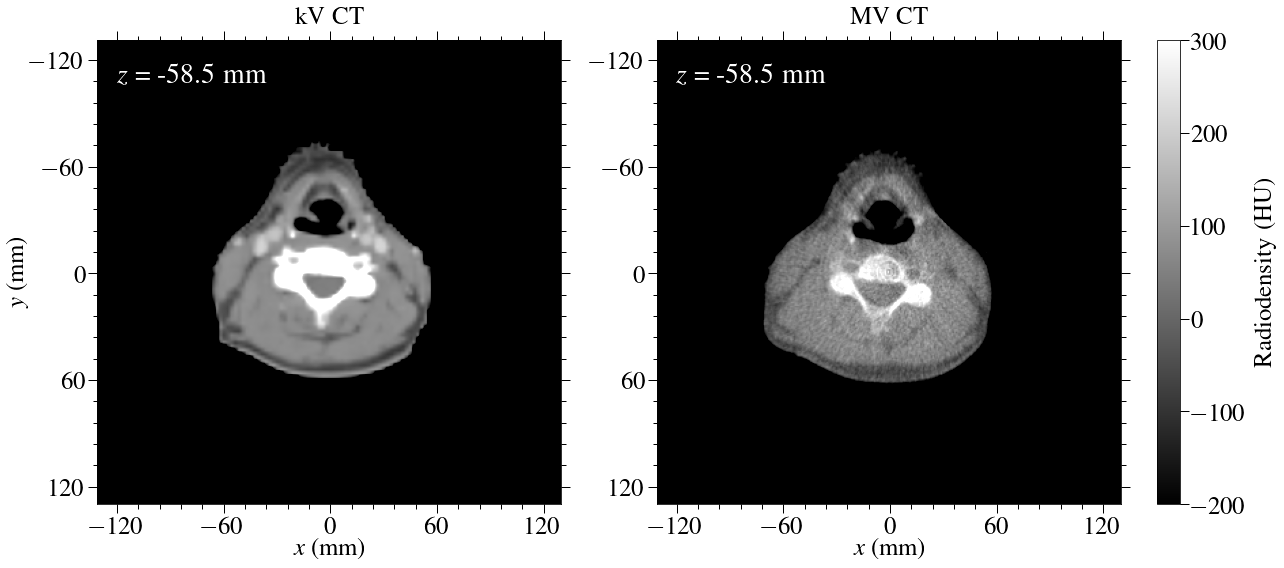

In [6]:
ct.match_size(mvct);

ct.print_geometry();
print();
mvct.print_geometry();

BetterViewer(images=[ct, mvct], **view_opts);

Map from radiodensities for kV X-rays to radiodensities for MV X-rays.

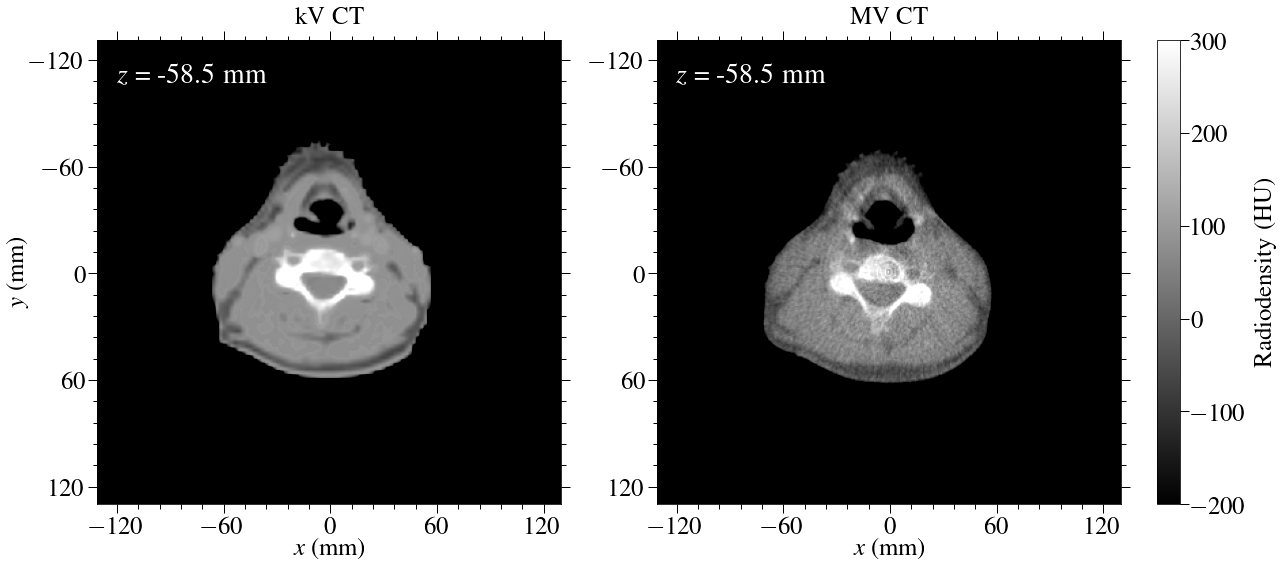

In [7]:
ct.map_hu('kv_to_mv');
BetterViewer(images=[ct, mvct], **view_opts)

Add noise at the level of image sinograms.

In [8]:
ct.add_sinogram_noise();

Display image slice selected at random, randomising also the order of transformed kV CT image and MV CT image.

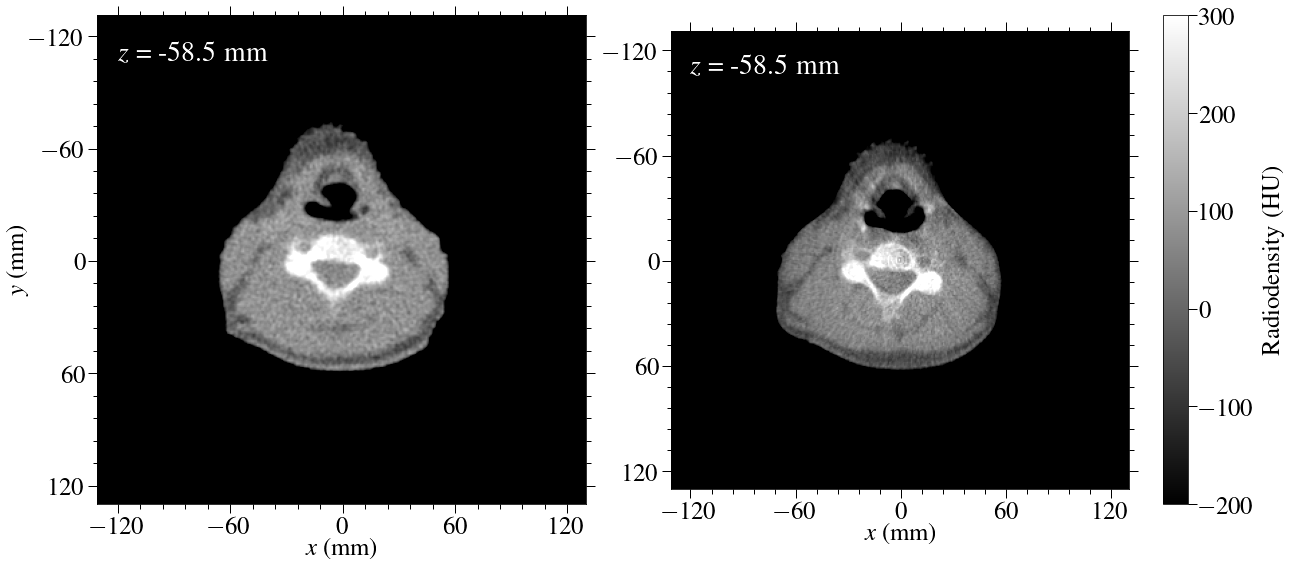

In [9]:
images = [ct, mvct];
init_slice = randint(1, ct.get_n_voxels()[2]);
shuffle(images);
view_opts["title"] = ["", ""]
BetterViewer(images=images, init_slice=init_slice, **view_opts);

Reveal which is the transformed kV CT image and which is the MV CT image.

In [10]:
print(f'left: {images[0].image_type}; right: {images[1].image_type}');

left: ct; right: mvct


The result is an image that has the characteristics of an MV CT image, and for which regions of interest were outlined at planning time.

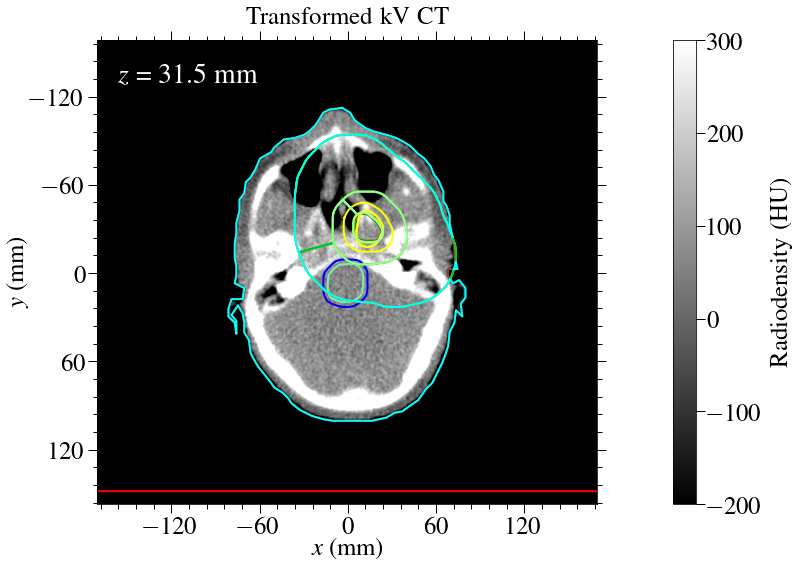

In [11]:
view_opts["title"] = ["Transformed kV CT"]
ct.structure_sets[0].view(**view_opts);